# Análisis de Sentimientos usando RNN

Se analizará los sentimientos en comentarios de peliculas...


In [1]:
import numpy as np
import collections as col
from keras.datasets import imdb
from matplotlib import pyplot as plt

np.random.seed(3)
(X_train, y_train), (X_test, y_test) = imdb.load_data(seed=15)

# Distribucion del largo


Distribución de largo de comentarios: 


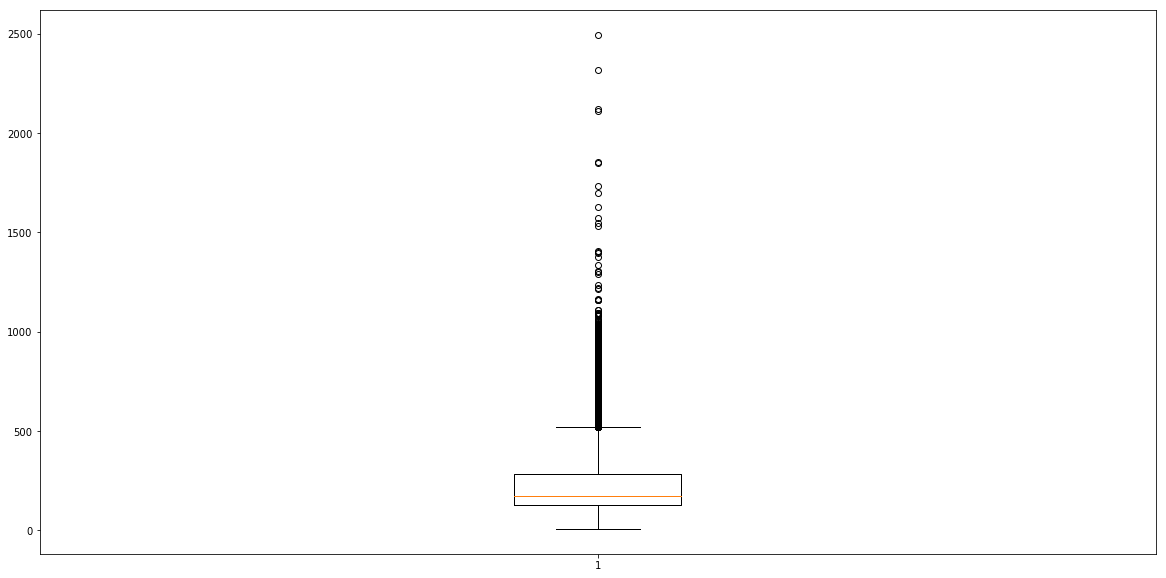

In [2]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

print("Distribución de largo de comentarios: ")
result = list(map(len, X))
plt.figure(figsize=(20,10))
plt.boxplot(result)
plt.show()


In [3]:
frecuencias = {}
for comentario in X:
    for palabra in comentario:
        if palabra not in frecuencias:
            frecuencias[palabra] = 1
        else:
            frecuencias[palabra] += 1
vocabulario = len(frecuencias)
ploty = []
for valor,freq in frecuencias.items():
    ploty.append(freq)

plotx = range(vocabulario)
desc_freq = list(reversed(sorted(ploty)))
maximo = max(desc_freq)
print(maximo)

666757


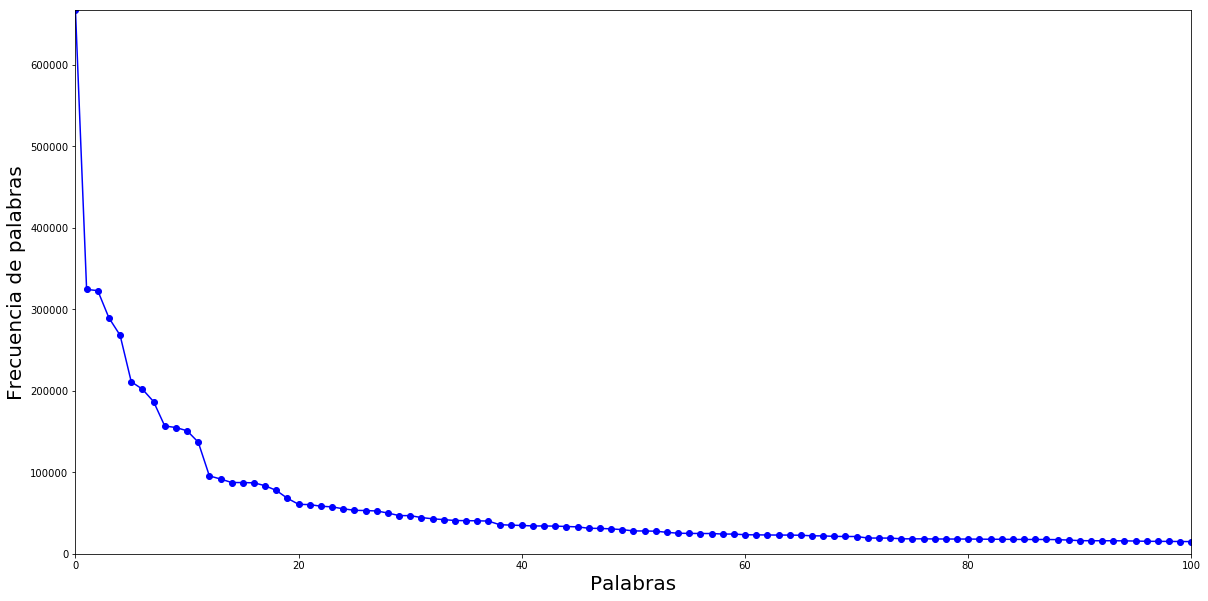

In [4]:
plt.figure(figsize=(20,10))
plt.plot(plotx,desc_freq,'bo-')
plt.xlabel("Palabras",fontsize=20)
plt.ylabel("Frecuencia de palabras",fontsize=20)
plt.xlim(0,100)
plt.ylim(0,666800)
plt.show()

>Cambia el resultado cuando se separan los
textos de acuerdo a su clase/categora?

## Comentarios de largo fijo 

(c) Cargue nuevamente el dataset, pero esta vez extrayendo solo las 3000 palabras mas relevantes y acotando
el largo maximo para un comentario en 500 palabras. Los comentarios con un largo menor deben ser
rellenados con 0 (padding). >Porque es necesario hacer esto ultimo?

In [5]:
imdb.load_data(nb_words=3000, seed=15)
from keras.preprocessing import sequence
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)


C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\keras\datasets\imdb.py:44: UserWarning: The `nb_words` argument in `load_data` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `load_data` '


## Entrenar red LSMT

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
embedding_vector_length = 32
top_words = 88585
model = Sequential()
model.add(Embedding(top_words+2, embedding_vector_length, input_length=500))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist1 = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
scores1 = model.evaluate(X_test, y_test, verbose=0)

C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 1468s - loss: 0.4547 - acc: 0.7767 - val_loss: 0.3233 - val_acc: 0.8672
Epoch 2/3
25000/25000 [==============================] - 1423s - loss: 0.2442 - acc: 0.9058 - val_loss: 0.3452 - val_acc: 0.8586
Epoch 3/3
25000/25000 [==============================] - 29671s - loss: 0.1889 - acc: 0.9328 - val_loss: 0.4076 - val_acc: 0.8607


# Variación de embedding

In [ ]:
embedding_vector_length = 32
embedding1 = int((embedding_vector_length)/2)
embedding2 = int(2*(embedding_vector_length))

#Con la mitad del embedding original
model = Sequential()
model.add(Embedding(top_words+2, embedding1, input_length=500))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist2 = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
scores2 = model.evaluate(X_test, y_test, verbose=0)

#Con el doble del embedding original
model = Sequential()
model.add(Embedding(top_words+2, embedding2, input_length=500))
model.add(LSTM(100))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
hist3 = model.fit(X_train, y_train, validation_data=(X_test, y_test), nb_epoch=3, batch_size=64)
scores3 = model.evaluate(X_test, y_test, verbose=0)

C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 1248s - loss: 0.5538 - acc: 0.7330 - val_loss: 0.4426 - val_acc: 0.8026
Epoch 2/3
25000/25000 [==============================] - 1318s - loss: 0.3569 - acc: 0.8644 - val_loss: 0.3981 - val_acc: 0.8360
Epoch 3/3
25000/25000 [==============================] - 1469s - loss: 0.2223 - acc: 0.9173 - val_loss: 0.3764 - val_acc: 0.8390
Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 1678s - loss: 0.4194 - acc: 0.8044 - val_loss: 0.3591 - val_acc: 0.8458
Epoch 2/3
25000/25000 [==============================] - 1728s - loss: 0.2432 - acc: 0.9070 - val_loss: 0.3464 - val_acc: 0.8570
Epoch 3/3
25000/25000 [==============================] - 1686s - loss: 0.1289 - acc: 0.9545 - val_loss: 0.3833 - val_acc: 0.8352


In [ ]:
print(scores2,scores3)

# f)

## g) Dropout para entrenar LSTM

In [ ]:
from keras.layers import Dropout

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(top_words+2, embedding_vector_length, input_length=500))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())
hist4 = model.fit(X_train, y_train, nb_epoch=3, batch_size=64)
scores4 = model.evaluate(X_test, y_test, verbose=0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           2834784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 2,888,085
Trainable params: 2,888,085
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\fabian\Anaconda3\envs\tensorflow\lib\site-packages\keras\models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/3
25000/25000 [==============================] - 1300s - loss: 0.6915 - acc: 0.5955  
Epoch 2/3
25000/25000 [==============================] - 1271s - loss: 0.4246 - acc: 0.8154  
Epoch 3/3
17600/25000 [====================>.........] - ETA: 401s - loss: 0.2043 - acc: 0.9253

## h) Modelo propuesto para mejorar capacidad predictiva